In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

Загружаем датасет

In [3]:
data = pd.read_csv("healthcare-dataset-stroke-data.csv")
data.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


Очевидно, что id пациента никак не поможет предсказать случится ли у него инслуьт или нет

In [4]:
data = data.drop(columns='id')
data.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [5]:
to_delete = data[data['gender'] == 'Other'].index
data = data.drop(to_delete)

In [6]:
data.dtypes

gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

Посмотрим на пропущенные данные

In [7]:
data.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [8]:
data.groupby('gender')['bmi'].mean()

gender
Female    29.065758
Male      28.647936
Name: bmi, dtype: float64

In [9]:
data = data.fillna(data.mean())
data.isnull().sum()

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

In [10]:
data.ever_married.unique()

array(['Yes', 'No'], dtype=object)

In [11]:
data.work_type.unique()

array(['Private', 'Self-employed', 'Govt_job', 'children', 'Never_worked'],
      dtype=object)

In [12]:
data.Residence_type.unique()

array(['Urban', 'Rural'], dtype=object)

In [13]:
data.smoking_status.unique()

array(['formerly smoked', 'never smoked', 'smokes', 'Unknown'],
      dtype=object)

Заменим значения категориальных признаков численными

In [14]:
from sklearn.preprocessing import LabelEncoder
categorial_cols = data.columns[data.dtypes=='object'].to_list()
l = LabelEncoder()
data[categorial_cols] = data[categorial_cols].apply(lambda col : l.fit_transform(col))

In [15]:
data.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1,67.0,0,1,1,2,1,228.69,36.60000,1,1
1,0,61.0,0,0,1,3,0,202.21,28.89456,2,1
2,1,80.0,0,1,1,2,0,105.92,32.50000,2,1
3,0,49.0,0,0,1,2,1,171.23,34.40000,3,1
4,0,79.0,1,0,1,3,0,174.12,24.00000,2,1


In [16]:
data.dtypes

gender                 int64
age                  float64
hypertension           int64
heart_disease          int64
ever_married           int64
work_type              int64
Residence_type         int64
avg_glucose_level    float64
bmi                  float64
smoking_status         int64
stroke                 int64
dtype: object

In [17]:
from sklearn.preprocessing import StandardScaler

numerical_cols = data.columns[data.dtypes=='float64']

scaler = StandardScaler()
data[numerical_cols] = scaler.fit_transform(data[numerical_cols])

data[numerical_cols]

,age,avg_glucose_level,bmi
0,1.051242,2.706450,1.001034e+00
1,0.785889,2.121652,1.384627e-15
2,1.626174,-0.004867,4.683922e-01
3,0.255182,1.437473,7.152261e-01
4,1.581949,1.501297,-6.358651e-01
...,...,...,...
5105,1.626174,-0.494481,1.384627e-15
5106,1.670400,0.420922,1.442737e+00
5107,-0.363976,-0.511266,2.215582e-01
5108,0.343633,1.328375,-4.280049e-01


Разобьем датасет на обучающую и тестовую части

In [29]:
from sklearn.model_selection import train_test_split
x = data.drop('stroke', axis=1).values
y = data['stroke'].values
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.10)

#Логистическая регрессия


In [19]:
def sigmoid(z):
  return 1 / (1 + np.exp(-z))

class LogisticRegressor:
  def __init__(self):
    self.loss = []

  def count_loss(self, x, y):
    z = np.dot(x, self.weights)
    predicted_true = y * np.log(sigmoid(z))
    predicted_false = (1 - y) * np.log(1 - sigmoid(z))
    return -np.sum(predicted_true + predicted_false) / x.shape[0]

  def fit(self, x, y, nepoch=1000, lr=0.01, log_loss=False):
    self.weights = np.random.rand(x.shape[1])
    for _ in range(nepoch):
      predicted = sigmoid(np.dot(x, self.weights))
      self.weights -= lr * np.dot(x.T, predicted - y) / x.shape[0]
      if log_loss:
        self.loss.append(self.count_loss(x, y))

  def predict(self, x):
    prediction = np.dot(x, self.weights)
    return [1 if predict > 0.5 else 0 for predict in sigmoid(prediction)]



In [30]:
from sklearn.metrics import accuracy_score, confusion_matrix
lgr = LogisticRegressor()
lgr.fit(x_train, y_train)
predicted = lgr.predict(x_test)
accuracy_score(predicted, y_test)

0.9471624266144814

In [31]:
from sklearn.linear_model import LogisticRegressionCV
lr = LogisticRegressionCV()
lr.fit(x_train, y_train)
predicted = lr.predict(x_test)
accuracy_score(predicted, y_test)

0.9530332681017613

In [32]:
hyperparameters = [
(0.1, 500), 
(0.1, 1000), 
(0.1, 1500),
(0.01, 1000),
(0.01, 2000),
(0.01, 5000),
(0.01, 10000),
(0.001, 1000),
(0.001, 3000),
(0.001, 5000),
(0.001, 10000),
(0.001, 15000),
(0.0001, 2000),
(0.0001, 5000),
(0.0001, 10000),
(0.0001, 15000),
(0.0001, 20000),
(0.0001, 50000)
]

for pair in hyperparameters:
    lr, nepoch = pair
    lgr = LogisticRegressor()
    lgr.fit(x_train, y_train, nepoch=nepoch, lr=lr)
    predicted_test = lgr.predict(x_test)
    predicted_train = lgr.predict(x_train)
    print(f'Learning rate = {lr}, nepoch = {nepoch}, train accuracy = {accuracy_score(y_train, predicted_train)}, test accuracy = {accuracy_score(y_test, predicted_test)}')

Learning rate = 0.1, nepoch = 500, train accuracy = 0.9441061331013484, test accuracy = 0.949119373776908
Learning rate = 0.1, nepoch = 1000, train accuracy = 0.9454110482818617, test accuracy = 0.949119373776908
Learning rate = 0.1, nepoch = 1500, train accuracy = 0.9451935624184428, test accuracy = 0.949119373776908
Learning rate = 0.01, nepoch = 1000, train accuracy = 0.9371465854719443, test accuracy = 0.9432485322896281
Learning rate = 0.01, nepoch = 2000, train accuracy = 0.9436711613745107, test accuracy = 0.949119373776908
Learning rate = 0.01, nepoch = 5000, train accuracy = 0.9454110482818617, test accuracy = 0.9510763209393346
Learning rate = 0.01, nepoch = 10000, train accuracy = 0.9464984775989561, test accuracy = 0.949119373776908
Learning rate = 0.001, nepoch = 1000, train accuracy = 0.8405828621139626, test accuracy = 0.8160469667318982
Learning rate = 0.001, nepoch = 3000, train accuracy = 0.9197477163984341, test accuracy = 0.9217221135029354
Learning rate = 0.001, ne

Наилучшая точность была достигнута с lr = 0.01 и количеством эпох равным 5000. Посмотрим на loss для этих параметров

0.18832845796309783


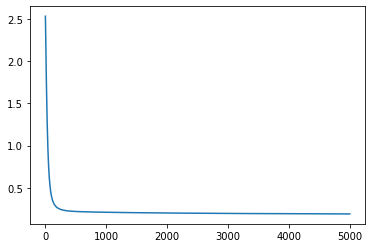

In [33]:
lgr = LogisticRegressor()
lgr.fit(x_train, y_train, nepoch=5000, lr=0.01, log_loss=True)
predicted = lgr.predict(x_test)
accuracy_score(predicted, y_test)
plt.plot([i + 1 for i in range(len(lgr.loss))], lgr.loss)
print(lgr.loss[-1])

In [34]:
confusion_matrix(predicted, y_test)

array([[481,  22],
       [  6,   2]])

Видно, что модель почти для всех наблюдений предсказывает true

#Дерево решений

In [158]:
class Node:
  def __init__(self, feature_index=None, feature_value=None, left=None, 
               right=None, info_gain=0, predicted_value=None):
    self.feature_index = feature_index
    self.feature_value = feature_value
    self.left = left
    self.right = right
    self.info_gain = info_gain
    self.predicted_value = predicted_value


class ClassifyingDecisionTree:
  def __init__(self, max_depth=2, min_samples_split=2):
    self.max_depth = max_depth
    self.min_samples_split = min_samples_split

  def fit(self, x, y):
    data = np.concatenate((x, y[:, np.newaxis]), axis=1)
    self.root = self.build_tree(data)

  def predict(self, x):
    predicted = [self.single_prediction(obs, self.root) for obs in x]
    return predicted

  def single_prediction(self, x, node):
    if node.predicted_value != None:
      return node.predicted_value

    if x[node.feature_index] <= node.feature_value:
      return self.single_prediction(x, node.left)
    else:
      return self.single_prediction(x, node.right)

  def gini(self, rows):
    unique = np.unique(rows)
    impurity = 1
    for cls in unique:
      prob = len(rows[rows == cls]) / float(len(rows))
      impurity -= prob ** 2
    return impurity

  def info_gain(self, current_uncertainty, left, right):
    p = float(len(left)) / (len(left) + len(right))
    return current_uncertainty - p * self.gini(left) - (1 - p) * self.gini(right)

  def split(self, data, feature_index, feature_value):
    left = np.array([item for item in data if item[feature_index] <= feature_value])
    right = np.array([item for item in data if item[feature_index] > feature_value])
    return left, right

  def find_best_split(self, data, num_features):
    best_split = Node()
    current_uncertainty = self.gini(data[:, -1])
    for feature_index in range(num_features):
      feature_values = data[:, feature_index]
      for feature_value in np.unique(feature_values):
        left, right = self.split(data, feature_index, feature_value)
        if len(left) == 0 or len(right) == 0:
          continue
        gain = self.info_gain(current_uncertainty, left[:, -1], right[:, -1])
        if gain > best_split.info_gain:
          best_split.feature_index = feature_index
          best_split.feature_value = feature_value
          best_split.left = left
          best_split.right = right
          best_split.info_gain = gain
    return best_split

  def build_tree(self, data, current_depth=0):
    X, Y = data[:, :-1], data[:, -1]
    num_samples, num_features = np.shape(X)
    if num_samples >= self.min_samples_split and current_depth <= self.max_depth:
      best_split = self.find_best_split(data, num_features)
      if best_split.info_gain > 0:
        left = self.build_tree(best_split.left, current_depth + 1)
        right = self.build_tree(best_split.right, current_depth + 1)
        best_split.left = left
        best_split.right = right
        return best_split
    value = max(list(Y), key=list(Y).count)
    return Node(predicted_value=value)    



Сравним результаты для деревьев с высотой 1, 2, 4

In [159]:
depths = [1, 2, 4]
for depth in depths:
  crt = ClassifyingDecisionTree(max_depth=depth)
  crt.fit(x_train, y_train)
  predicted = crt.predict(x_test)
  print("Depth = {}, accuracy = {}".format(depth, accuracy_score(predicted, y_test)))

Depth = 1, accuracy = 0.9530332681017613
Depth = 2, accuracy = 0.9510763209393346
Depth = 4, accuracy = 0.9510763209393346


In [160]:
from sklearn.tree import DecisionTreeClassifier
for depth in depths:
  sk_crt = DecisionTreeClassifier(max_depth=depth)
  sk_crt.fit(x_train, y_train)
  predicted = sk_crt.predict(x_test)
  print("Depth = {}, accuracy = {}".format(depth, accuracy_score(predicted, y_test)))

Depth = 1, accuracy = 0.9530332681017613
Depth = 2, accuracy = 0.9530332681017613
Depth = 4, accuracy = 0.9530332681017613


#Random forest

In [172]:
from collections import Counter

class RandomForest:
  def __init__(self, num_trees=10, max_depth=2, min_samples_split=2):
    self.num_trees = num_trees
    self.max_depth = max_depth
    self.min_samples_split = min_samples_split
    self.forest = []

  def get_sample(self, x, y):
    random_rows = np.random.choice(a=x.shape[0], size=x.shape[0])
    return x[random_rows], y[random_rows]

  def fit(self, x, y):
    for _ in range(self.num_trees):
      sample_x, sample_y = self.get_sample(x, y)
      tree = ClassifyingDecisionTree(self.max_depth, self.min_samples_split)
      tree.fit(sample_x, sample_y)
      self.forest.append(tree)

  def predict(self, x):
    prediction = []
    y = []
    for tree in self.forest:
      y.append(tree.predict(x))
    y = np.swapaxes(a=y, axis1=0, axis2=1)  
    for obs in y:
      counter = Counter(obs)
      prediction.append(counter.most_common(1)[0][0])
    return prediction  



Посмотрим на результаты, когда лес состоит из 2, 5, 10, 20 деревьев

In [186]:
num_trees = [2, 5, 10, 20]
for n in num_trees:
  forest = RandomForest(num_trees=n)
  forest.fit(x_train, y_train)
  predicted = forest.predict(x_test)
  print("Number of trees = {}, accuracy = {}".format(n, accuracy_score(predicted, y_test)))

Number of trees = 2, accuracy = 0.9530332681017613
Number of trees = 5, accuracy = 0.9530332681017613
Number of trees = 10, accuracy = 0.9530332681017613
Number of trees = 20, accuracy = 0.9530332681017613


In [185]:
from sklearn.ensemble import RandomForestClassifier

for n in num_trees:
  forest = RandomForestClassifier(n_estimators=n)
  forest.fit(x_train, y_train)
  predicted = forest.predict(x_test)
  print("Number of trees = {}, accuracy = {}".format(n, accuracy_score(predicted, y_test)))

Number of trees = 2, accuracy = 0.9412915851272016
Number of trees = 5, accuracy = 0.9452054794520548
Number of trees = 10, accuracy = 0.9569471624266145
Number of trees = 20, accuracy = 0.9549902152641878
